In [1]:
!uv pip install -q --system --force-reinstall numba-cuda==0.4.0

from numba import cuda
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import math

In [3]:
rgb = cv2.imread("Lenna.png")
imageHeight, imageWidth, _ = rgb.shape
print(imageHeight, imageWidth)
pixelCount = imageHeight * imageWidth
rgb = np.reshape(rgb, (pixelCount, 3))
print(rgb.shape)

500 500
(250000, 3)


In [4]:
def grayscale_cpu(src, dst):
  for i in range(pixelCount):
    g = np.uint8((int(src[i, 0]) + int(src[i, 1]) + int(src[i, 2])) / 3)
    dst[i, 0] = dst[i, 1] = dst[i, 2] = g
  return dst

In [9]:
avgtime = []
for _ in range(10):
  gray = np.zeros((pixelCount, 3), dtype=np.uint8)
  start = time.time()
  grayscale_cpu_image = grayscale_cpu(rgb, gray)
  avgtime.append(time.time() - start)
print(f"Average time processed on CPU: {np.mean(avgtime)}s")
grayscale_cpu_image = grayscale_cpu_image.reshape((imageHeight, imageWidth, 3))
cv2.imwrite(f"Lenna_gray_cpu.png", grayscale_cpu_image)

Average time processed on CPU: 0.4067821502685547s


In [10]:
@cuda.jit
def grayscale_gpu(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  g = np.uint8((src[tidx, 0] + src[tidx, 1] + src[tidx, 2]) / 3)
  dst[tidx, 0] = dst[tidx, 1] = dst[tidx, 2] = g

In [19]:
devOutput = cuda.device_array((pixelCount, 3), np.uint8)
devInput = cuda.to_device(rgb)
blockSize = [32, 64, 128, 256, 512, 1024]
timeProcess = []

for b in blockSize:
  gridSize = math.ceil(pixelCount / b)
  avgtime = []
  for _ in range(10):
    start = time.time()
    grayscale_gpu[gridSize, b](devInput, devOutput)
    avgtime.append(time.time() - start)
    hostOutput = devOutput.copy_to_host()
    grayscale_gpu_image = hostOutput.reshape((imageHeight, imageWidth, 3))
  cv2.imwrite(f"Lenna_gray_gpu_{b}.png", grayscale_gpu_image)
  timeProcess.append(np.mean(avgtime))
  print(f"Time processed with block size {b}: {np.mean(avgtime)}s")


Average time processed on GPU with block size 32: 0.0002749919891357422s
Average time processed on GPU with block size 64: 0.00018134117126464844s
Average time processed on GPU with block size 128: 0.00011363029479980469s
Average time processed on GPU with block size 256: 0.00012094974517822266s
Average time processed on GPU with block size 512: 0.0001163482666015625s
Average time processed on GPU with block size 1024: 0.000121307373046875s


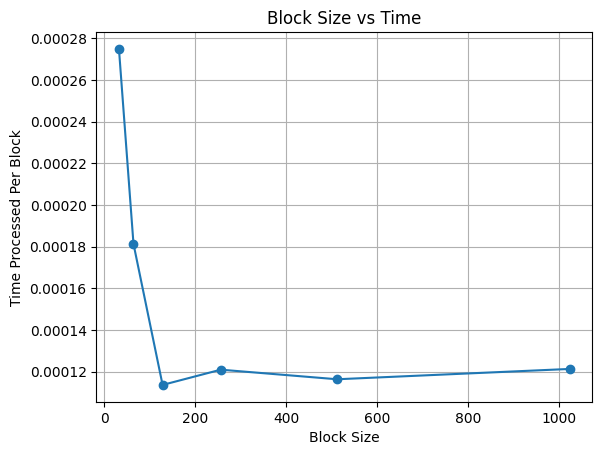

In [20]:
plt.plot(blockSize, timeProcess, marker='o')
plt.title("Block Size vs Time")
plt.xlabel("Block Size")
plt.ylabel("Time Processed Per Block")
plt.grid(True)
# plt.savefig("comparison.png")
plt.show()